Установка библиотек визуализации...
Файл kaggle.json уже настроен.
Установка библиотеки kaggle...
Скачивание датасета loan-train.csv...
Датасет loan-train.csv успешно скачан.

--- Предобработка данных ---
Удалено строк с пустым Loan_ID: 0
Пропущенные значения в столбцах Gender, Married, Dependents, Self_Employed, Credit_History заполнены модой.
Пропущенные значения в столбцах LoanAmount, Loan_Amount_Term заполнены медианой.
Типы числовых столбцов приведены к Int64/float для совместимости.
Итоговое количество строк после предобработки: 614

Подключение к базе данных 'loan_data.db' установлено.
Таблица 'loan_applications' успешно создана или уже существовала.
Данные (614 строк) успешно импортированы в таблицу 'loan_applications'.

--- Выполнение SQL-запроса: SELECT * ---
Запрос SELECT * выполнен. Всего строк в таблице: 614

Имена столбцов: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',

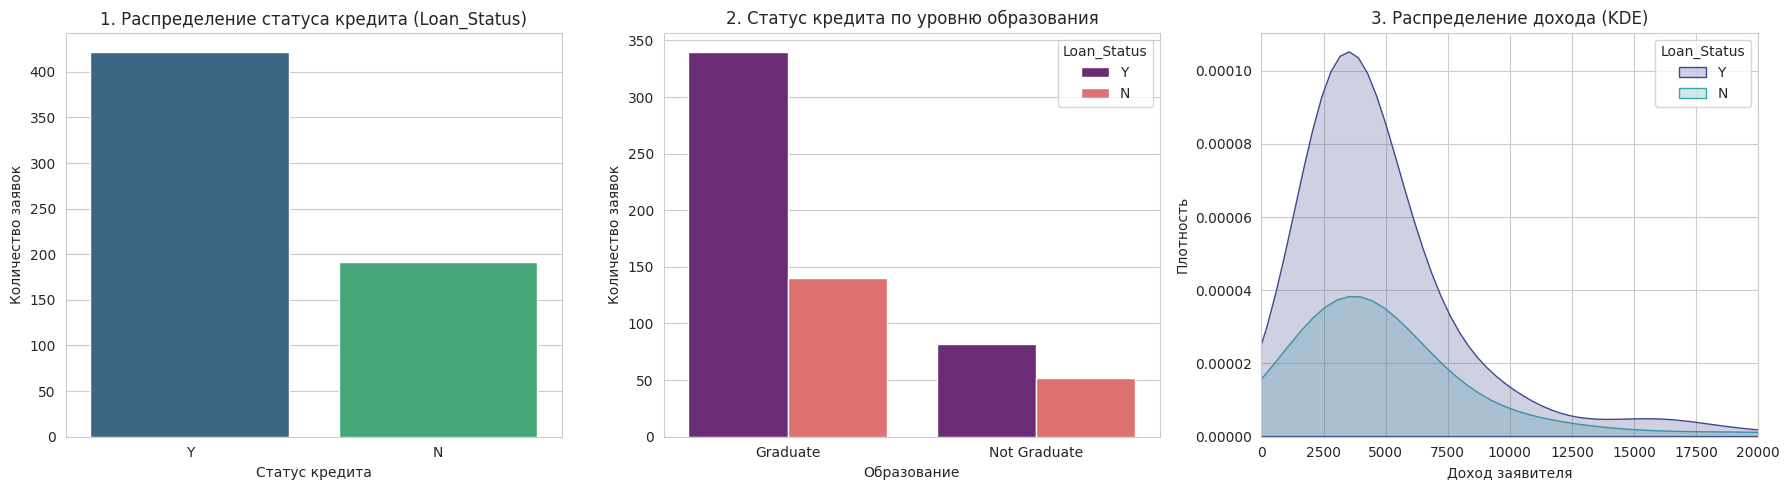

Графики построены и отображены.

Соединение с базой данных закрыто.


In [5]:
import os
import shutil
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Константы для Kaggle и файлов
DATASET_ID = 'vikasukani/loan-eligible-dataset'
FILE_NAME = 'loan-train.csv'
DB_NAME = 'loan_data.db'
TABLE_NAME = 'loan_applications'

# Игнорирование предупреждений для чистоты вывода
warnings.filterwarnings('ignore')


def setup_kaggle_config():
    """
    Настраивает окружение Kaggle, копируя kaggle.json в нужную директорию.
    """
    kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
    token_path = os.path.join(kaggle_dir, 'kaggle.json')

    # Создание директории, если ее нет
    os.makedirs(kaggle_dir, exist_ok=True)

    # Копирование и установка прав доступа
    if not os.path.exists(token_path) and os.path.exists('kaggle.json'):
        shutil.copyfile('kaggle.json', token_path)
        os.chmod(token_path, 0o600)
        print("Файл kaggle.json скопирован и настроен.")
    elif os.path.exists(token_path):
        print("Файл kaggle.json уже настроен.")
    else:
        print("ВНИМАНИЕ: Пожалуйста, загрузите файл kaggle.json в текущую сессию Colab.")


def download_dataset():
    """
    Устанавливает библиотеку kaggle и скачивает датасет.
    """
    print("Установка библиотеки kaggle...")
    os.system('pip install kaggle -q')

    print(f"Скачивание датасета {FILE_NAME}...")
    # Выполнение команды для скачивания
    os.system(f'kaggle datasets download -d {DATASET_ID} --file {FILE_NAME}')

    if os.path.exists(FILE_NAME):
        print(f"Датасет {FILE_NAME} успешно скачан.")
        return True
    else:
        print(f"ОШИБКА: Не удалось скачать файл {FILE_NAME}. Проверьте токен Kaggle.")
        return False


def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Выполняет предобработку данных: обработку пропусков и приведение типов.

    :param df: Исходный Pandas DataFrame.
    :return: Предобработанный Pandas DataFrame.
    """
    print("\n--- Предобработка данных ---")

    initial_rows = len(df)

    # 1. Удаление строк с пропущенными ключевыми значениями
    df = df.dropna(subset=['Loan_ID'])
    print(f"Удалено строк с пустым Loan_ID: {initial_rows - len(df)}")

    # 2. Обработка пропущенных значений (NaN)

    # Категориальные (заполнение модой)
    cat_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']
    for col in cat_cols:
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)

    # Числовые (заполнение медианой)
    num_cols = ['LoanAmount', 'Loan_Amount_Term']
    for col in num_cols:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

    print(f"Пропущенные значения в столбцах {', '.join(cat_cols)} заполнены модой.")
    print(f"Пропущенные значения в столбцах {', '.join(num_cols)} заполнены медианой.")

    # 3. Приведение типов для SQLite
    # Для Loan_Amount_Term, Credit_History лучше использовать целые числа (INTEGER)
    df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype('Int64')
    df['Credit_History'] = df['Credit_History'].astype('Int64')
    df['ApplicantIncome'] = df['ApplicantIncome'].astype('Int64')

    print("Типы числовых столбцов приведены к Int64/float для совместимости.")
    print(f"Итоговое количество строк после предобработки: {len(df)}")

    return df


def create_and_load_data(df: pd.DataFrame, conn: sqlite3.Connection):
    """
    Создает таблицу в SQLite и импортирует данные из DataFrame.

    :param df: Предобработанный Pandas DataFrame.
    :param conn: Активное соединение с базой данных SQLite.
    """
    cursor = conn.cursor()

    # Определение схемы таблицы SQLite. Типы скорректированы после предобработки.
    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS {TABLE_NAME} (
        Loan_ID TEXT PRIMARY KEY,
        Gender TEXT,
        Married TEXT,
        Dependents TEXT,
        Education TEXT,
        Self_Employed TEXT,
        ApplicantIncome INTEGER,
        CoapplicantIncome REAL,
        LoanAmount REAL,
        Loan_Amount_Term INTEGER,
        Credit_History INTEGER,
        Property_Area TEXT,
        Loan_Status TEXT
    );
    """

    try:
        cursor.execute(create_table_query)
        conn.commit()
        print(f"Таблица '{TABLE_NAME}' успешно создана или уже существовала.")
    except sqlite3.Error as e:
        print(f"Ошибка при создании таблицы: {e}")
        return

    # Импорт данных с использованием метода to_sql
    try:
        df.to_sql(TABLE_NAME, conn, if_exists='replace', index=False)
        conn.commit()
        print(f"Данные ({len(df)} строк) успешно импортированы в таблицу '{TABLE_NAME}'.")
    except Exception as e:
        print(f"Ошибка при импорте данных: {e}")
        conn.rollback()


def query_all_rows(conn: sqlite3.Connection):
    """
    Выполняет запрос SELECT * и выводит первые 5 строк.

    :param conn: Активное соединение с базой данных SQLite.
    """
    cursor = conn.cursor()
    select_all_query = f"SELECT * FROM {TABLE_NAME};"

    print("\n--- Выполнение SQL-запроса: SELECT * ---")
    try:
        cursor.execute(select_all_query)
        rows = cursor.fetchall()

        print(f"Запрос SELECT * выполнен. Всего строк в таблице: {len(rows)}")

        if rows:
            # Получение имен столбцов
            column_names = [description[0] for description in cursor.description]
            print("\nИмена столбцов:", column_names)
            print("\nПервые 5 строк:")
            for row in rows[:5]:
                print(row)
        else:
            print("В таблице нет данных.")

    except sqlite3.Error as e:
        print(f"Ошибка при выполнении запроса: {e}")


def query_analysis_data(conn: sqlite3.Connection):
    """
    Выполняет аналитический запрос: подсчет заявок по статусу.

    :param conn: Активное соединение с базой данных SQLite.
    """
    cursor = conn.cursor()
    analysis_query = f"""
    SELECT
        Loan_Status,
        COUNT(Loan_ID) AS Total_Applications
    FROM {TABLE_NAME}
    GROUP BY Loan_Status;
    """

    print("\n--- Выполнение SQL-запроса: Анализ Loan_Status ---")
    try:
        cursor.execute(analysis_query)
        results = cursor.fetchall()

        if results:
            print("Результаты группировки по Loan_Status:")
            # Получение имен столбцов для аналитического запроса
            column_names = [description[0] for description in cursor.description]
            print(f"{column_names[0]:<15} | {column_names[1]}")
            print("-" * 30)
            for row in results:
                print(f"{row[0]:<15} | {row[1]}")
        else:
            print("Не удалось получить аналитические данные.")

    except sqlite3.Error as e:
        print(f"Ошибка при выполнении аналитического запроса: {e}")


def visualize_data(conn: sqlite3.Connection):
    """
    Извлекает данные из SQLite и строит графики для анализа.

    :param conn: Активное соединение с базой данных SQLite.
    """
    print("\n--- Визуализация данных ---")

    try:
        # Извлечение всех данных из SQLite в Pandas DataFrame
        df_sql = pd.read_sql(f"SELECT * FROM {TABLE_NAME}", conn)
    except Exception as e:
        print(f"Ошибка при извлечении данных из БД для визуализации: {e}")
        return

    # Настройка стиля Seaborn
    sns.set_style("whitegrid")

    # Создание области для трех графиков
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

    # --- График 1: Распределение целевой переменной (Loan_Status) ---
    sns.countplot(x='Loan_Status', data=df_sql, palette='viridis', ax=axes[0])
    axes[0].set_title('1. Распределение статуса кредита (Loan_Status)')
    axes[0].set_xlabel('Статус кредита')
    axes[0].set_ylabel('Количество заявок')

    # --- График 2: Зависимость Loan_Status от Education ---
    sns.countplot(
        x='Education',
        hue='Loan_Status',
        data=df_sql,
        palette='magma',
        ax=axes[1]
    )
    axes[1].set_title('2. Статус кредита по уровню образования')
    axes[1].set_xlabel('Образование')
    axes[1].set_ylabel('Количество заявок')

    # --- График 3: Распределение дохода заявителя (ApplicantIncome) ---
    # KDE/Гистограмма для анализа численного признака
    sns.kdeplot(
        df_sql,
        x='ApplicantIncome',
        hue='Loan_Status',
        fill=True,
        palette='mako',
        ax=axes[2]
    )
    axes[2].set_title('3. Распределение дохода (KDE)')
    axes[2].set_xlabel('Доход заявителя')
    axes[2].set_ylabel('Плотность')
    # Ограничиваем ось X, чтобы исключить сильные выбросы и улучшить читаемость
    axes[2].set_xlim(0, 20000)

    plt.tight_layout()
    plt.show()
    print("Графики построены и отображены.")


def main():
    """
    Основная функция для выполнения всех шагов ETL (Extract, Transform, Load) и визуализации.
    """
    # Установка библиотек визуализации (часто уже установлены в Colab, но для надежности)
    print("Установка библиотек визуализации...")
    os.system('pip install matplotlib seaborn -q')

    # 1. Настройка Kaggle
    setup_kaggle_config()

    # 2. Скачивание датасета
    if not download_dataset():
        return

    # 3. Чтение данных
    try:
        df = pd.read_csv(FILE_NAME)
    except Exception as e:
        print(f"ОШИБКА: Не удалось прочитать CSV файл: {e}")
        return

    # 4. Преобразование данных (T - Transform)
    df_transformed = preprocess_data(df)

    # 5. Создание БД и загрузка данных (L - Load)
    conn = None
    try:
        conn = sqlite3.connect(DB_NAME)
        print(f"\nПодключение к базе данных '{DB_NAME}' установлено.")

        create_and_load_data(df_transformed, conn)

        # 6. Выполнение запросов для проверки
        query_all_rows(conn)
        query_analysis_data(conn)

        # 7. Визуализация данных
        visualize_data(conn)

    except sqlite3.Error as e:
        print(f"Критическая ошибка соединения с БД: {e}")
    finally:
        if conn:
            conn.close()
            print("\nСоединение с базой данных закрыто.")


if __name__ == '__main__':
    main()